In [1]:
import oggm.cfg as cfg
from oggm import tasks, graphics, utils, workflow
from oggm.core import flowline
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import scipy
import os
import matplotlib.pyplot as plt
import salem
from scipy.stats.mstats import rankdata
# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display
from oggm.core.gis import gaussian_blur

import shapely.geometry as shpg
from scipy.ndimage import binary_erosion,distance_transform_edt
from oggm.utils import ncDataset

This notebook is a proposal on how to redistribute the glacier ice that has been simulated allong the flowline after a simulation where the glacier has been retreating. Extrapolating the glacier ice onto a map comes with some assumptions and trade-offs. Depending on the purpose one might like to make different choices. e.g. for visualisation, one might like to use more smoothing, than when using the output to put in for instance a hydrological model. It would offcourse be possible to add different option to the final function, so one can select the option that is best for their needs, however that hasn't been included yet. 

This notebook uses one glacier to show how this redistribution can be done. It has as purpose to discuss it further, before it enters the OGGM code base. 

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
rgi_region = '11'  # Region Central Europe

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_distr4')
cfg.PATHS['working_dir'] = WORKING_DIR
cfg.PARAMS['prcp_scaling_factor'] = 2.5
cfg.PARAMS['climate_qc_months']=3

2022-10-04 13:59:20: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-10-04 13:59:20: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-10-04 13:59:20: oggm.cfg: Multiprocessing: using all available processors (N=16)
2022-10-04 13:59:20: oggm.cfg: WARNING: adding an unknown parameter `prcp_scaling_factor`:`2.5` to PARAMS.
2022-10-04 13:59:20: oggm.cfg: PARAMS['climate_qc_months'] changed from `0` to `3`.


In [3]:
print(WORKING_DIR)

/tmp/OGGM/OGGM_distr4


In [4]:
# RGI file
path = utils.get_rgi_region_file(rgi_region)
rgidf = gpd.read_file(path)

# Select a glacier
rgidf = rgidf.loc[rgidf[rgidf.columns[0]] == 'RGI60-11.01450']
# rgidf = rgidf.loc[rgidf[rgidf.columns[0]] == 'RGI60-11.00897']

base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match/'
gdirs = workflow.init_glacier_directories(rgidf, from_prepro_level=3, prepro_border=40, prepro_base_url=base_url)
gdir = gdirs[0]

2022-10-04 13:59:20: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2022-10-04 13:59:20: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [5]:
# Distribute
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdir);

2022-10-04 13:59:21: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers


In [6]:
ds = xr.open_dataset(gdirs[0].get_filepath('gridded_data'))

In [7]:
tasks.run_constant_climate(gdir, nyears=100, y0=2000, temperature_bias=0.25, store_fl_diagnostics=True)
f = gdir.get_filepath('fl_diagnostics')
with xr.open_dataset(f) as di:
    fl_ids = di.flowlines.data

In [8]:
# We pick the last flowline (the main one)
with xr.open_dataset(f, group=f'fl_{fl_ids[-1]}') as dg:
    dg = dg.load()                             

In [9]:
# select year 0 from simulation
dg2 = dg[dict(time=0)]
# ice covered points along the flowline
tongue = np.sum([dg2.thickness_m!=0])

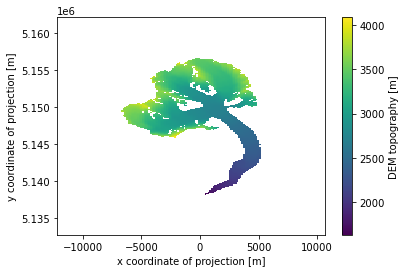

In [10]:
# Plot the glacier topo
ds.where(ds.glacier_mask==1).topo.plot()

In [11]:
# Create an array with only the topo on the glacier and substract X meter from the elevation of glaciers on the outline. 
# This value is arbritary, but seems to result in a more realistic retreat of the glacier tongue than 
# that without this correction. A physical explanation for this might be that there is an influence of steep valley walls 
# along the tongue on the glacier DEM, causing the sides of the glacier to be higher than the center. 
border_correction = 40 
topo_correction = xr.where(ds.glacier_mask==1, ds.topo, np.nan) - (xr.where(ds.glacier_mask==1, ds.glacier_ext, np.nan) * border_correction)
topo_correction.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [12]:
# This smooting function is used to only smooth the topo of the glacier, and excludes the surrounding in the process.
# (It is therefore different that the smoothing that occurs in the 'process_dem' function, that generates 'topo_smoothed'
# in the gridded_data.nc file.) This is of importance because the sides on a glacier tongue can other wise be higher that 
# the middle, resulting in an odd shape once the glacier retreats (e.g. the middle of the tongue retreating faster 
# that the edges). 

def filter_nan_gaussian_conserving(arr, sigma):
    """Apply a gaussian filter to an array with nans.

    Intensity is only shifted between not-nan pixels and is hence conserved.
    The intensity redistribution with respect to each single point
    is done by the weights of available pixels according
    to a gaussian distribution.
    All nans in arr, stay nans in gauss.
    """
    nan_msk = np.isnan(arr)

    loss = np.zeros(arr.shape)
    loss[nan_msk] = 1
    loss = scipy.ndimage.gaussian_filter(
            loss, sigma=sigma, mode='constant', cval=1)

    gauss = arr.copy()
    gauss[nan_msk] = 0
    gauss = scipy.ndimage.gaussian_filter(
            gauss, sigma=sigma, mode='constant', cval=0)
    gauss[nan_msk] = np.nan

    gauss += loss * arr

    return gauss

In [13]:
check2 = filter_nan_gaussian_conserving(topo_correction.values, 1)

ds["checkje"] = xr.full_like(ds.topo, fill_value=np.nan)

for ki in np.arange(len(ds.x)): 
    for kj in np.arange(len(ds.y)):  
            ds["checkje"].loc[dict(y=ds.y[kj], x=ds.x[ki])] = check2[kj,ki]


In [14]:
#number of pixels in section along flowline
npix1 = dg2.area_m2/(gdir.grid.dx**2)
npix_rcumsum = np.around(npix1.values[::-1].cumsum()[::-1])
npix = npix_rcumsum[0:-2] - npix_rcumsum[1:-1]
npix

array([  4.,  20.,  99., 252., 294., 319., 387., 293., 214., 175., 192.,
       219., 177., 111.,  85.,  71.,  59.,  52.,  55.,  53.,  57.,  60.,
        60.,  57.,  54.,  43.,  34.,  26.,  19.,  18.,  19.,  20.,  21.,
        21.,  21.,  22.,  24.,  26.,  25.,  26.,  28.,  28.,  28.,  27.,
        26.,  28.,  27.,  23.,  27.,  27.,  22.,  23.,  28.,  28.,  26.,
        26.,  24.,  20.,  13.,  14.,  13.,  12.,  14.,  14.,  12.,  18.,
         9.,   7.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.])

In [15]:
ds['topo_smoothed'] = ds.checkje

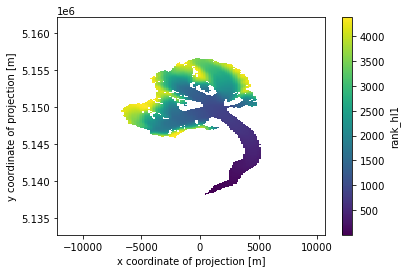

In [16]:
#optie 1
rank_hl1 = rankdata(ds.where(ds.glacier_mask==1).topo_smoothed)
# optie 2
# rank_hl1 = rankdata(ds.where(ds.glacier_mask==1).topo_smoothed + ds.distributed_thickness)

# optie 3
# rank_hl1 = rankdata(ds.where(ds.glacier_mask==1).topo_smoothed + (ds.distributed_thickness/2))

# optie 4
# rank_hl1 = rankdata(ds.where(ds.glacier_mask==1).topo_smoothed + (ds.distributed_thickness/2)+ (ds.dis_from_border/gdir.grid.dx))

# optie 4
# rank_hl1 = rankdata(ds.where(ds.glacier_mask==1).topo_smoothed + ((ds.dis_from_border/4)**0.6)) # (ds.distributed_thickness/20)+ 

# optie 5
# rank_hl1 = rankdata(ds.where(ds.glacier_mask==1).topo + ((ds.dis_from_border**0.25)*2))
# rank_hl1 = rankdata(ds.where(ds.glacier_mask==1).topo)

ds['rank_hl1'] = (('y', 'x'), rank_hl1)
# ds['rank_hl1'] = ds['rank_hl1'][ds['rank_hl1'].values>1562]
ds['rank_hl1'] = ds.where(ds.glacier_mask==1).rank_hl1
ds.where(ds.glacier_mask==1).rank_hl1.plot()

In [17]:
gdir.grid.dx

137.0

In [18]:
ds["fl_att"] = xr.full_like(ds.rank_hl1, fill_value=np.nan)

for ki in ds.x: 
    for kj in ds.y:
        check = ds.sel(y=kj, x=ki).rank_hl1.values
        if not np.isnan(check):
            kn = np.sum(npix_rcumsum >= check)        
            ds["fl_att"].loc[dict(y=kj, x=ki)] = kn

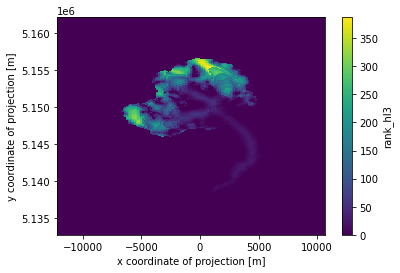

In [19]:
ds["fl_att_sub"] = xr.full_like(ds.rank_hl1, fill_value=np.nan)
ds["rank_hl2"] = xr.full_like(ds.rank_hl1, fill_value=0)


# for ki in np.arange(18):
for ki in np.arange(len(npix)):
    ds["rank_hl2_" + str(ki)] = xr.full_like(ds.rank_hl1, fill_value=0)
    rank_hl2 = rankdata(ds.distributed_thickness.where(ds.fl_att==ki))
    ds["rank_hl2_" + str(ki)] = (('y', 'x'), rank_hl2)
    # ds.where(ds.fl_att==1).rank_hl2.plot()
    ds["rank_hl2_" + str(ki)] = ds["rank_hl2_" + str(ki)].where(ds.fl_att==ki, 0)

rank_hl3 = ds.rank_hl2_0.values

for ki in np.arange(1,np.max(ds.fl_att)):
    rank_hl3 = rank_hl3 + (ds['rank_hl2_' + str(int(ki))]).values
    
ds["rank_hl3"] = xr.full_like(ds.rank_hl1, fill_value=np.nan)
ds["rank_hl3"] = (('y', 'x'), rank_hl3)
ds.rank_hl3.plot()



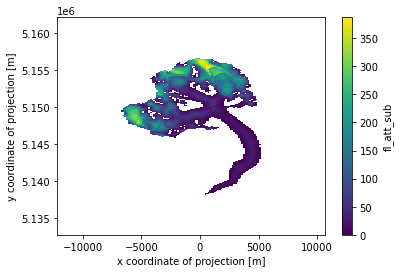

In [20]:
ds['fl_att_sub']=ds.where(ds.glacier_mask==1).rank_hl3
ds.fl_att_sub.plot()

In [21]:
def distribute_thick(gdir, yr=0, mask=None, topo=None):

    # start of implementing distributing glacier thickness
    # Variables

    dis_from_border_exp=0.25 # pas op aangepast!
    smooth_radius=None
    grids_file = gdir.get_filepath('gridded_data')
    # See if we have the masks, else compute them
    with utils.ncDataset(grids_file) as nc:
        has_masks = 'glacier_ext_erosion' in nc.variables

    with utils.ncDataset(grids_file) as nc:
        topo_smoothed = nc.variables['topo_smoothed'][:]
        slope_factor = nc.variables['slope_factor'][:]
#         topo_smoothed = nc.variables['topo_smoothed'][:]
        topo_smoothed = nc.variables['topo'][:]
        if yr==0:
            glacier_mask = nc.variables['glacier_mask'][:]
            dis_from_border = nc.variables['dis_from_border'][:]
        else:
            glacier_mask = mask
#             topo_smoothed = topo
            # Glacier exterior including nunataks
            gdfi = gpd.GeoDataFrame(columns=['geometry'])
            erode = binary_erosion(glacier_mask)
            glacier_ext = glacier_mask ^ erode
            glacier_ext = np.where(glacier_mask == 1, glacier_ext, 0)

            dist = np.array([])
            jj, ii = np.where(glacier_ext)
            for j, i in zip(jj, ii):
                dist = np.append(dist, np.min(gdfi.distance(shpg.Point(i, j))))

            pok = np.where(dist <= 1)
            glacier_ext_intersect = glacier_ext * 0
            glacier_ext_intersect[jj[pok], ii[pok]] = 1

            # Distance from border mask - Scipy does the job
            dx = gdir.grid.dx
            dis_from_border = 1 + glacier_ext_intersect - glacier_ext
            dis_from_border = distance_transform_edt(dis_from_border) * dx
#             topo_smoothed = ds.topo_smoothed[:].values - np.nan_to_num(ds["new_thick_" + str(int(yr-1))][:].values - ds['distributed_thickness'][:].values)
            topo_smoothed = ds.topo[:].values - np.nan_to_num(ds["new_thick_" + str(int(yr-1))][:].values - ds['distributed_thickness'][:].values)

#             topo_smoothed = topo_smoothed - ds['distributed_thickness'][:].values + ds["new_thick_" + str(int(yr-1))][:].values

    # Along the lines
    hs, ts, vs, xs, ys = [], [], [], [], []
    hs = dg.thickness_m[dict(time=yr)].values + dg.bed_h.values
    ts = dg.thickness_m[dict(time=yr)]
    vs = dg.volume_m3[dict(time=yr)]
    # Squeezed flowlines, dummy coords
    x = hs * 0 - 1
    y = hs * 0 - 1
    xs = np.append(xs, x)
    ys = np.append(ys, y)
    init_vol = np.sum(vs)

    # Assign a first order thickness to the points
    # very inefficient inverse distance stuff
    thick = glacier_mask * np.NaN
    for y in range(thick.shape[0]):
        for x in range(thick.shape[1]):
            phgt = topo_smoothed[y, x]
            # take the ones in a 100m range
            starth = 100.
            while True:
                starth += 10
                pok = np.nonzero(np.abs(phgt - hs) <= starth)[0]
                if len(pok) != 0:
                    break
            sqr = np.sqrt((xs[pok]-x)**2 + (ys[pok]-y)**2)
            pzero = np.where(sqr == 0)
            if len(pzero[0]) == 0:
                thick[y, x] = np.average(ts[pok], weights=1 / sqr)
            elif len(pzero[0]) == 1:
                thick[y, x] = ts[pzero]
            else:
                raise RuntimeError('We should not be there')

    # Distance from border (normalized)
    dis_from_border = dis_from_border**dis_from_border_exp
    dis_from_border /= np.mean(dis_from_border[glacier_mask == 1])
    thick *= dis_from_border

    # Slope
    thick *= slope_factor

    # Smooth
    dx = gdir.grid.dx
    if smooth_radius != 0:
        if smooth_radius is None:
            smooth_radius = np.rint(cfg.PARAMS['smooth_window'] / dx)
        thick = gaussian_blur(thick, int(smooth_radius))
        thick = np.where(glacier_mask, thick, 0.)

    # Re-mask
    utils.clip_min(thick, 0, out=thick)
    thick[glacier_mask == 0] = np.NaN
    assert np.all(np.isfinite(thick[glacier_mask == 1]))

    # Conserve volume
    tmp_vol = np.nansum(thick * dx**2)
    thick *= (init_vol / tmp_vol).values
    
    ds["new_thick_" + str(int(yr))] = xr.full_like(ds.rank_hl1, fill_value=np.nan)
    ds["new_thick_" + str(int(yr))] = (('y', 'x'), thick)

In [22]:
def compute_extend(yr=0, ds=ds):
    ds["fl_att_sub"] = xr.full_like(ds.rank_hl1, fill_value=np.nan)
    ds["rank_hl2"] = xr.full_like(ds.rank_hl1, fill_value=0)

    for ki in np.arange(len(npix)):
        ds["rank_hl2_" + str(ki)] = xr.full_like(ds.rank_hl1, fill_value=0)
        rank_hl2 = rankdata(ds["new_thick_" + str(int(yr))].where(ds["new_thick_" + str(int(yr))]==ki))
        ds["rank_hl2_" + str(ki)] = (('y', 'x'), rank_hl2)
        ds["rank_hl2_" + str(ki)] = ds["rank_hl2_" + str(ki)].where(ds.fl_att==ki, 0)

    rank_hl3 = ds.rank_hl2_0.values

    for ki in np.arange(1,np.max(ds.fl_att)):
        rank_hl3 = rank_hl3 + (ds['rank_hl2_' + str(int(ki))]).values

    ds["rank_hl3"] = xr.full_like(ds.rank_hl1, fill_value=np.nan)
    ds["rank_hl3"] = (('y', 'x'), rank_hl3)
    ds['fl_att_sub']=ds.where(ds.glacier_mask==1).rank_hl3


    ds['extend_' + str(yr)] = xr.full_like(ds.rank_hl1, fill_value=np.nan)
    for ki in np.arange(len(npix),0,-1):
        if dg.sel(dict(time=yr)).area_m2[ki].values == 0:
            ds["extend_" + str(yr)] = xr.where(ds.fl_att==ki, np.nan, ds["extend_" + str(yr)])
        elif dg.sel(dict(time=yr)).area_m2[ki].values >= np.min([dg[dict(time=0)].area_m2[ki].values, \
                                                                 npix[ki]*(gdir.grid.dx**2)]):
            ds["extend_" + str(yr)] = xr.where(ds.fl_att==ki, ki, ds["extend_" + str(yr)]) 
        else:
            pix_cov = dg.sel(dict(time=yr)).area_m2[ki].values/(npix[ki]*(gdir.grid.dx**2))
            
            mask = ((ds.fl_att==ki) & (ds.fl_att_sub>=pix_cov))
            
            ds["extend_" + str(yr)] = xr.where(mask, ki, ds["extend_" + str(yr)]) 

In [23]:
distribute_thick(gdir, yr=0)
compute_extend(yr=0, ds=ds)

for yr in np.arange(1,100):
    compute_extend(yr=yr-1, ds=ds)
    distribute_thick(gdir, yr=yr, mask=ds.where(ds['extend_' + str(int(yr-1))]>0, 0).glacier_mask[:].values)

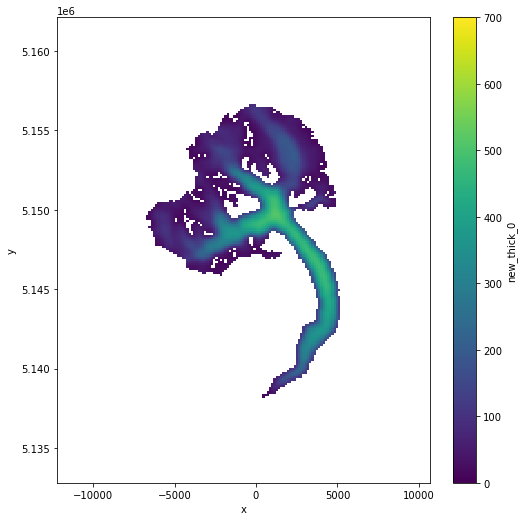

In [24]:
from matplotlib import animation

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(gdir.grid.nx/20,gdir.grid.ny/25))

# Plot the initial frame. 
cax = ds.new_thick_0.plot(
    add_colorbar=True,
    cmap='viridis',
    vmin=0, vmax=700,
    cbar_kwargs={
        'extend':'neither'
    }
)

def animate(frame):
    cax.set_array(ds['new_thick_' + str(int(frame))].values.flatten())

ani = animation.FuncAnimation(
    fig,            
    animate,        
    frames=100,      
    interval=200,     
    save_count=1500
)

In [25]:
HTML(ani.to_jshtml())

In [26]:
writervideo = animation.PillowWriter(fps=60)

ani.save(cfg.PATHS['working_dir'] + '/test.gif', writer=writervideo)